In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2, l1_l2

In [ ]:
# store csv contents in dataframe
file_path = "/content/Tweets.csv"

df = pd.read_csv(file_path)

In [ ]:
# drop rows/col with null values and only keep text and airline_sentiment columns
df = df[['text', 'airline_sentiment']].dropna()

In [ ]:
# categorical labels converted to integer labels
# neutral, positive, negative => 0 and 1
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['airline_sentiment'])

# converts labels into vectors
y = to_categorical(y)

In [ ]:
tokenizer = Tokenizer(oov_token=1)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
max_length = 30
batch_size = 32
epochs = 20

In [ ]:
# add padding (zeroes) at the end
X = np.array(pad_sequences(sequences, maxlen=max_length, padding='post'))

In [ ]:
# helps deal with large data sets by doing on-the-fly data encoding in batches
class OneHotDataGenerator(Sequence):

  def __init__(self, X, y, batch_size, vocab_size):

    self.X = X
    self.y = y
    self.batch_size = batch_size
    self.vocab_size = vocab_size
    self.indexes = np.arange(len(X))

  # total number of batches per epoch
  def __len__(self):
    return int(np.ceil(len(self.X) / self.batch_size))

  def __getitem__(self, index):
    batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
    batch_X = self.X[batch_indexes]
    batch_y = self.y[batch_indexes]

    batch_X_one_hot = np.zeros((batch_X.shape[0], max_length, self.vocab_size))

    for i, seq in enumerate(batch_X):
      for j, word_idx in enumerate(seq):
        if word_idx > 0:
          batch_X_one_hot[i, j, word_idx] = 1
    return batch_X_one_hot, batch_y

In [ ]:
#split into train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#split training data into train and validtion data
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [ ]:
# generators for train and validation data
train_generator = OneHotDataGenerator(X_train, Y_train, batch_size, vocab_size)
val_generator = OneHotDataGenerator(X_val, Y_val, batch_size, vocab_size)
test_generator = OneHotDataGenerator(X_test, Y_test, batch_size, vocab_size)

In [ ]:
#early stopping
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self, model):
    self.model_to_stop = model
  def on_epoch_end(self, epochs, logs={}):
    if(logs.get('accuracy')> 0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model_to_stop.stop_training = True

callback = []

# Base model, lr = 0.001

In [ ]:
from tensorflow.keras.optimizers import Adam

#Building the base_model
base_model = Sequential([
  SimpleRNN(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(32, activation='tanh', input_shape=(max_length, vocab_size)),
  Dense(256, activation='relu'),
  Dense(3, activation='softmax')])
base_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

base_model_callback = myCallback(model=base_model)
callback.append(base_model_callback)

history = base_model.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[0])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


293/293 ━━━━━━━━━━━━━━━━━━━━ 63s 199ms/step - accuracy: 0.6234 - loss: 0.8831 - val_accuracy: 0.7384 - val_loss: 0.6640
Epoch 2/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 167ms/step - accuracy: 0.8303 - loss: 0.4556 - val_accuracy: 0.7435 - val_loss: 0.6915
Epoch 3/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9613 - loss: 0.1229
Reached 95% accuracy so cancelling training!
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 161ms/step - accuracy: 0.9613 - loss: 0.1229 - val_accuracy: 0.6709 - val_loss: 0.9537


In [ ]:
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 30, 32)              │         505,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │           8,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,550,987 (5.92 MB)

 Trainable params: 516,995 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,033,992 (3.94 MB)

In [ ]:
base_model.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - accuracy: 0.6948 - loss: 0.8828


[0.8979830741882324, 0.692964494228363]

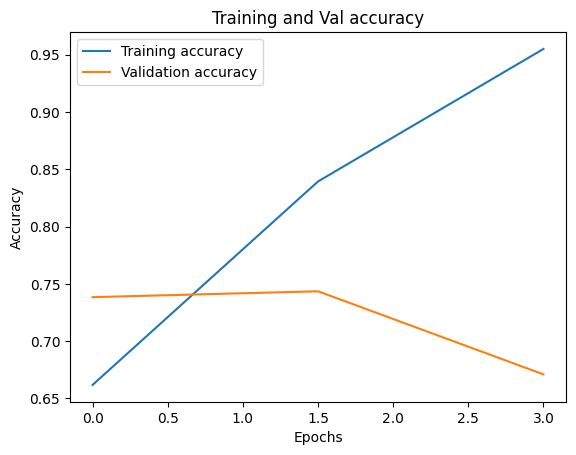

In [ ]:
plt.plot(np.linspace(0, len(history.history['accuracy']), len(history.history['accuracy'])), history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(history.history['val_accuracy']), len(history.history['val_accuracy'])), history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Lower learning rate, lr = 0.00001

In [ ]:
m1 = Sequential([
  SimpleRNN(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=False),
  Dense(256, activation='relu'),
  Dense(3, activation='softmax')])
m1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

m1_callback = myCallback(model=m1)
callback.append(m1_callback)

m1_history = m1.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[1])

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 53s 169ms/step - accuracy: 0.4721 - loss: 1.0662 - val_accuracy: 0.6116 - val_loss: 0.9627
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.6229 - loss: 0.9314 - val_accuracy: 0.6112 - val_loss: 0.9171
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 167ms/step - accuracy: 0.6219 - loss: 0.8951 - val_accuracy: 0.6155 - val_loss: 0.8793
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.6426 - loss: 0.8293 - val_accuracy: 0.6475 - val_loss: 0.8211
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.6811 - loss: 0.7525 - val_accuracy: 0.6603 - val_loss: 0.7784
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.6996 - loss: 0.6906 - val_accuracy: 0.6709 - val_loss: 0.7526
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 166ms/step - accuracy: 0.7101 - loss: 0.6571 - val_accuracy: 0.6846 - val_loss: 0.7376
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 163ms/step - accuracy: 0.7529 - loss: 0

In [ ]:
m1.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_26 (SimpleRNN)            │ (None, 30, 32)              │         505,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_27 (SimpleRNN)            │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │           8,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,550,987 (5.92 MB)

 Trainable params: 516,995 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,033,992 (3.94 MB)

In [ ]:
#predictions
m1.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.7254 - loss: 0.7685


[0.7502859830856323, 0.7325819730758667]

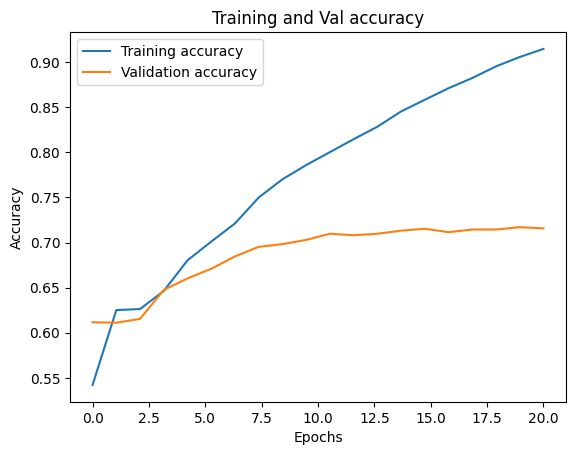

In [ ]:
plt.plot(np.linspace(0, len(m1_history.history['accuracy']), len(m1_history.history['accuracy'])), m1_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(m1_history.history['val_accuracy']), len(m1_history.history['val_accuracy'])), m1_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# RNN layers with small units

In [ ]:
m2 = Sequential([
  SimpleRNN(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(16, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(16, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=False),
  Dense(256, activation='relu'),
  Dense(3, activation='softmax')])
m2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

m2_callback = myCallback(model=m2)
callback.append(m2_callback)

m2_history = m2.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[2])

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 66s 207ms/step - accuracy: 0.3465 - loss: 1.0995 - val_accuracy: 0.5630 - val_loss: 1.0355
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.6041 - loss: 1.0053 - val_accuracy: 0.6112 - val_loss: 0.9578
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.6212 - loss: 0.9395 - val_accuracy: 0.6112 - val_loss: 0.9312
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.6175 - loss: 0.9139 - val_accuracy: 0.6137 - val_loss: 0.9135
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 162ms/step - accuracy: 0.6380 - loss: 0.8752 - val_accuracy: 0.6240 - val_loss: 0.8900
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.6565 - loss: 0.8398 - val_accuracy: 0.6342 - val_loss: 0.8710
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 46s 158ms/step - accuracy: 0.6643 - loss: 0.8079 - val_accuracy: 0.6453 - val_loss: 0.8511
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.6774 - loss: 0

In [ ]:
m2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_28 (SimpleRNN)            │ (None, 30, 32)              │         505,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_29 (SimpleRNN)            │ (None, 30, 32)              │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_30 (SimpleRNN)            │ (None, 30, 16)              │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_31 (SimpleRNN)            │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,542,635 (5.88 MB)

 Trainable params: 514,211 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,028,424 (3.92 MB)

In [ ]:
m2.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.7056 - loss: 0.7164


[0.7029867768287659, 0.7178961634635925]

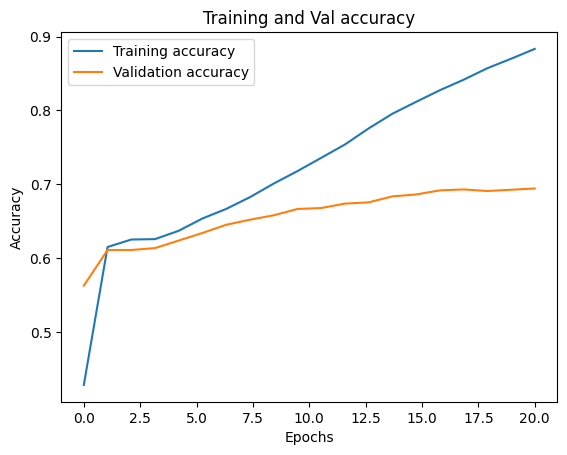

In [ ]:
plt.plot(np.linspace(0, len(m2_history.history['accuracy']), len(m2_history.history['accuracy'])), m2_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(m2_history.history['val_accuracy']), len(m2_history.history['val_accuracy'])), m2_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# RNN layers with more units

In [ ]:
m3 = Sequential([
  SimpleRNN(128, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(64, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(16, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=False),
  Dense(256, activation='relu'),
  Dense(3, activation='softmax')])
m3.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

m3_callback = myCallback(model=m3)
callback.append(m3_callback)

m3_history = m3.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[3])

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 56s 171ms/step - accuracy: 0.4531 - loss: 1.0594 - val_accuracy: 0.6112 - val_loss: 0.9437
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.6191 - loss: 0.9287 - val_accuracy: 0.6108 - val_loss: 0.9202
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.6265 - loss: 0.8876 - val_accuracy: 0.6560 - val_loss: 0.8359
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 162ms/step - accuracy: 0.6937 - loss: 0.7750 - val_accuracy: 0.6748 - val_loss: 0.7797
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.7362 - loss: 0.6684 - val_accuracy: 0.6867 - val_loss: 0.7389
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 46s 158ms/step - accuracy: 0.7642 - loss: 0.5948 - val_accuracy: 0.6978 - val_loss: 0.7174
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 84s 165ms/step - accuracy: 0.7944 - loss: 0.5466 - val_accuracy: 0.7029 - val_loss: 0.7063
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.8343 - loss: 0

In [ ]:
m3.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_32 (SimpleRNN)            │ (None, 30, 128)             │       2,035,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_33 (SimpleRNN)            │ (None, 30, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_34 (SimpleRNN)            │ (None, 30, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_35 (SimpleRNN)            │ (None, 16)                  │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,169,307 (23.53 MB)

 Trainable params: 2,056,435 (7.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,112,872 (15.69 MB)

In [ ]:
m3.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.7551 - loss: 0.7837


[0.8004821538925171, 0.750341534614563]

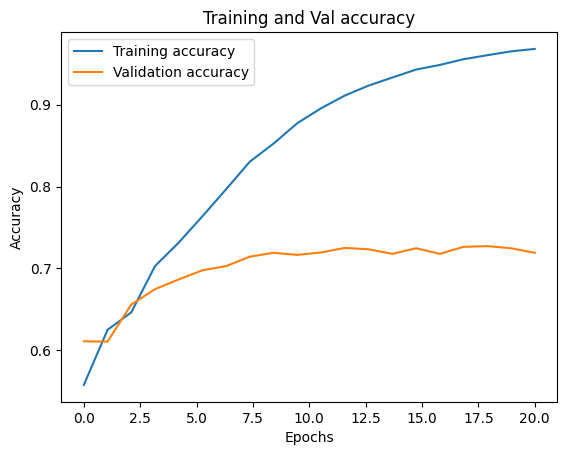

In [ ]:
plt.plot(np.linspace(0, len(m3_history.history['accuracy']), len(m3_history.history['accuracy'])), m3_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(m3_history.history['val_accuracy']), len(m3_history.history['val_accuracy'])), m3_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# RNNs with more Dense layers

In [ ]:
m4 = Sequential([
  SimpleRNN(128, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(64, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(16, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=False),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(3, activation='softmax')])
m4.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

m4_callback = myCallback(model=m4)
callback.append(m4_callback)

m4_history = m4.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[4])

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 57s 175ms/step - accuracy: 0.4322 - loss: 1.0506 - val_accuracy: 0.6112 - val_loss: 0.9360
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 76s 160ms/step - accuracy: 0.6141 - loss: 0.9174 - val_accuracy: 0.6423 - val_loss: 0.8315
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 163ms/step - accuracy: 0.6794 - loss: 0.7615 - val_accuracy: 0.6743 - val_loss: 0.7522
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.7244 - loss: 0.6489 - val_accuracy: 0.6714 - val_loss: 0.7182
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.7391 - loss: 0.6009 - val_accuracy: 0.6965 - val_loss: 0.7230
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 83s 166ms/step - accuracy: 0.7863 - loss: 0.5281 - val_accuracy: 0.7051 - val_loss: 0.6891
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.8284 - loss: 0.4581 - val_accuracy: 0.7179 - val_loss: 0.6936
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 163ms/step - accuracy: 0.8558 - loss: 0

In [ ]:
m4.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_36 (SimpleRNN)            │ (None, 30, 128)             │       2,035,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_37 (SimpleRNN)            │ (None, 30, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_38 (SimpleRNN)            │ (None, 30, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_39 (SimpleRNN)            │ (None, 16)                  │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,291,035 (24.00 MB)

 Trainable params: 2,097,011 (8.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,194,024 (16.00 MB)

In [ ]:
m4.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.7470 - loss: 0.9942


[0.9859299659729004, 0.7465847134590149]

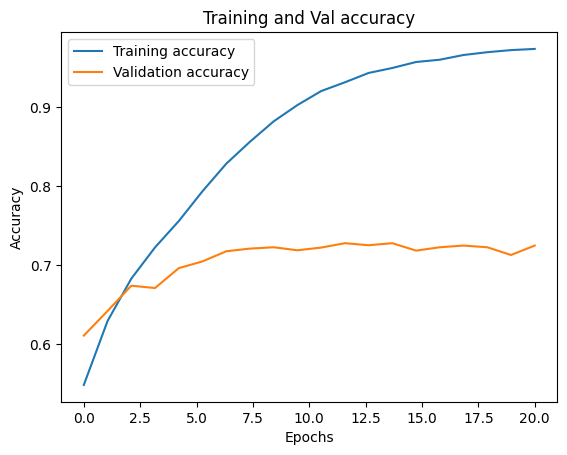

In [ ]:
plt.plot(np.linspace(0, len(m4_history.history['accuracy']), len(m4_history.history['accuracy'])), m4_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(m4_history.history['val_accuracy']), len(m4_history.history['val_accuracy'])), m4_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adding Regularization

In [ ]:
m5 = Sequential([
  SimpleRNN(128, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(64, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(16, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=False),
  Dense(256, activation='relu', kernel_regularizer=l2(0.03)),
  Dense(128, activation='relu', kernel_regularizer=l2(0.03)),
  Dense(64, activation='relu', kernel_regularizer=l2(0.03)),
  Dense(3, activation='softmax')])
m5.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

m5_callback = myCallback(model=m5)
callback.append(m5_callback)

m5_history = m5.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[5])

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 58s 174ms/step - accuracy: 0.4599 - loss: 9.5716 - val_accuracy: 0.6112 - val_loss: 9.1230
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.6177 - loss: 8.9796 - val_accuracy: 0.6112 - val_loss: 8.6144
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.6215 - loss: 8.4754 - val_accuracy: 0.6253 - val_loss: 8.1369
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 165ms/step - accuracy: 0.6444 - loss: 7.9730 - val_accuracy: 0.6500 - val_loss: 7.6619
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 163ms/step - accuracy: 0.6904 - loss: 7.4836 - val_accuracy: 0.6765 - val_loss: 7.2148
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.7299 - loss: 7.0217 - val_accuracy: 0.6850 - val_loss: 6.8143
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 161ms/step - accuracy: 0.7409 - loss: 6.5991 - val_accuracy: 0.6918 - val_loss: 6.4433
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 81s 158ms/step - accuracy: 0.7782 - loss: 6

In [ ]:
m5.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_40 (SimpleRNN)            │ (None, 30, 128)             │       2,035,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_41 (SimpleRNN)            │ (None, 30, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_42 (SimpleRNN)            │ (None, 30, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_43 (SimpleRNN)            │ (None, 16)                  │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,291,035 (24.00 MB)

 Trainable params: 2,097,011 (8.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,194,024 (16.00 MB)

In [ ]:
m5.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.7190 - loss: 3.1595


[3.145920753479004, 0.7295082211494446]

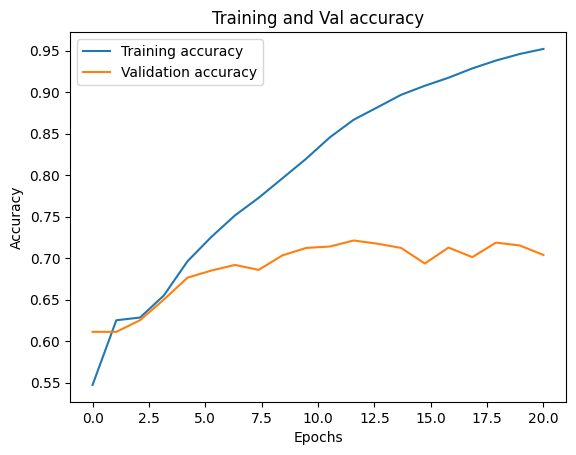

In [ ]:
plt.plot(np.linspace(0, len(m5_history.history['accuracy']), len(m5_history.history['accuracy'])), m5_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(m5_history.history['val_accuracy']), len(m5_history.history['val_accuracy'])), m5_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adding dropouts to Dense layers

In [ ]:
m6 = Sequential([
  SimpleRNN(128, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(64, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  SimpleRNN(16, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=False),
  Dense(256, activation='relu', kernel_regularizer=l2(0.03)),
  Dropout(0.2),
  Dense(128, activation='relu', kernel_regularizer=l2(0.03)),
  Dropout(0.2),
  Dense(64, activation='relu', kernel_regularizer=l2(0.03)),
  Dropout(0.2),
  Dense(3, activation='softmax')])
m6.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

m6_callback = myCallback(model=m6)
callback.append(m6_callback)

m6_history = m6.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[6])

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 60s 177ms/step - accuracy: 0.4478 - loss: 9.5807 - val_accuracy: 0.6116 - val_loss: 9.1584
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 162ms/step - accuracy: 0.6204 - loss: 9.0193 - val_accuracy: 0.6112 - val_loss: 8.6454
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.6318 - loss: 8.5279 - val_accuracy: 0.6125 - val_loss: 8.1945
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.6287 - loss: 8.0670 - val_accuracy: 0.6368 - val_loss: 7.6941
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.6652 - loss: 7.5601 - val_accuracy: 0.6658 - val_loss: 7.2532
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.7082 - loss: 7.0968 - val_accuracy: 0.6709 - val_loss: 6.8611
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 159ms/step - accuracy: 0.7345 - loss: 6.6768 - val_accuracy: 0.6761 - val_loss: 6.5034
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 46s 157ms/step - accuracy: 0.7412 - loss: 6

In [ ]:
m6.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_44 (SimpleRNN)            │ (None, 30, 128)             │       2,035,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_45 (SimpleRNN)            │ (None, 30, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_46 (SimpleRNN)            │ (None, 30, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_47 (SimpleRNN)            │ (None, 16)                  │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,291,035 (24.00 MB)

 Trainable params: 2,097,011 (8.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,194,024 (16.00 MB)

In [ ]:
m6.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.6819 - loss: 3.2540


[3.2358031272888184, 0.6857923269271851]

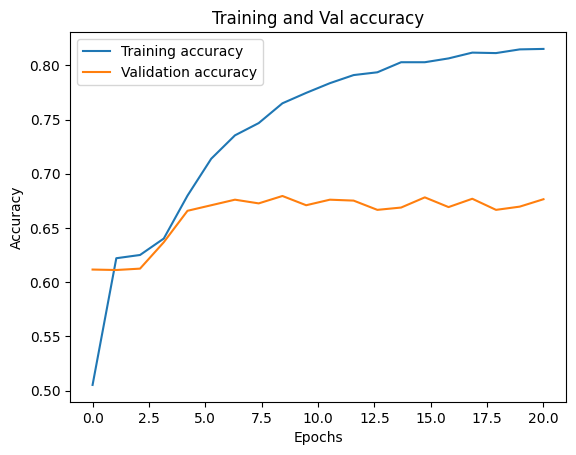

In [ ]:
plt.plot(np.linspace(0, len(m6_history.history['accuracy']), len(m6_history.history['accuracy'])), m6_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(m6_history.history['val_accuracy']), len(m6_history.history['val_accuracy'])), m6_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adding dropouts to RNN layers

In [ ]:
m7 = Sequential([
  SimpleRNN(128, activation='tanh', input_shape=(max_length, vocab_size), dropout=0.2, return_sequences=True),
  SimpleRNN(64, activation='tanh', input_shape=(max_length, vocab_size), dropout=0.2, return_sequences=True),
  SimpleRNN(32, activation='tanh', input_shape=(max_length, vocab_size), dropout=0.2, return_sequences=True),
  SimpleRNN(16, activation='tanh', input_shape=(max_length, vocab_size), dropout=0.2, return_sequences=False),
  Dense(256, activation='relu', kernel_regularizer=l2(0.03)),
  Dropout(0.2),
  Dense(128, activation='relu', kernel_regularizer=l2(0.03)),
  Dropout(0.2),
  Dense(64, activation='relu', kernel_regularizer=l2(0.03)),
  Dropout(0.2),
  Dense(3, activation='softmax')])
m7.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

m7_callback = myCallback(model=m7)
callback.append(m7_callback)

m7_history = m7.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[7])

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 65s 183ms/step - accuracy: 0.5264 - loss: 9.5553 - val_accuracy: 0.6112 - val_loss: 9.1680
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.6046 - loss: 9.0448 - val_accuracy: 0.6112 - val_loss: 8.6707
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 159ms/step - accuracy: 0.6254 - loss: 8.5621 - val_accuracy: 0.6112 - val_loss: 8.2304
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.6204 - loss: 8.1382 - val_accuracy: 0.6112 - val_loss: 7.8210
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 162ms/step - accuracy: 0.6213 - loss: 7.7261 - val_accuracy: 0.6112 - val_loss: 7.3825
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.6186 - loss: 7.2983 - val_accuracy: 0.6112 - val_loss: 6.9611
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 162ms/step - accuracy: 0.6395 - loss: 6.8775 - val_accuracy: 0.6530 - val_loss: 6.5734
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.6559 - loss: 6

In [ ]:
m7.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_48 (SimpleRNN)            │ (None, 30, 128)             │       2,035,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_49 (SimpleRNN)            │ (None, 30, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_50 (SimpleRNN)            │ (None, 30, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_51 (SimpleRNN)            │ (None, 16)                  │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,291,035 (24.00 MB)

 Trainable params: 2,097,011 (8.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,194,024 (16.00 MB)

In [ ]:
m7.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.6962 - loss: 3.1417


[3.1255199909210205, 0.6991119980812073]

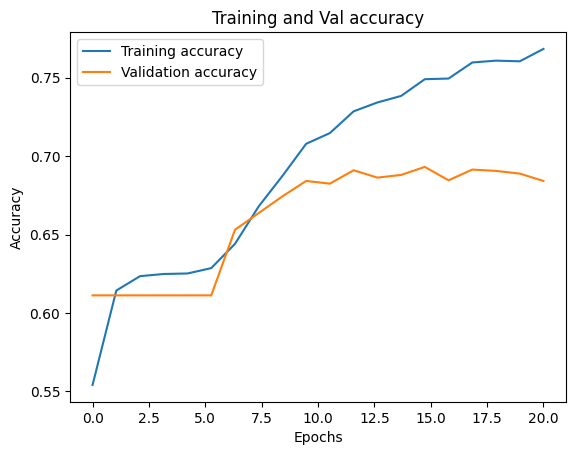

In [ ]:
plt.plot(np.linspace(0, len(m7_history.history['accuracy']), len(m7_history.history['accuracy'])), m7_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(m7_history.history['val_accuracy']), len(m7_history.history['val_accuracy'])), m7_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Using L1_L2 Regularizer

In [ ]:
m8 = Sequential([
  SimpleRNN(128, activation='tanh', input_shape=(max_length, vocab_size), dropout=0.2, return_sequences=True),
  SimpleRNN(64, activation='tanh', input_shape=(max_length, vocab_size), dropout=0.2, return_sequences=True),
  SimpleRNN(32, activation='tanh', input_shape=(max_length, vocab_size), dropout=0.2, return_sequences=True),
  SimpleRNN(16, activation='tanh', input_shape=(max_length, vocab_size), dropout=0.2, return_sequences=False),
  Dense(256, activation='relu', kernel_regularizer=l2(0.03)),
  Dropout(0.2),
  Dense(128, activation='relu', kernel_regularizer=l1_l2(0.03)),
  Dropout(0.2),
  Dense(64, activation='relu', kernel_regularizer=l1_l2(0.03)),
  Dropout(0.2),
  Dense(3, activation='softmax')])
m8.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

m8_callback = myCallback(model=m8)
callback.append(m8_callback)

m8_history = m8.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[8])

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 65s 186ms/step - accuracy: 0.2407 - loss: 84.4025 - val_accuracy: 0.3414 - val_loss: 81.6782
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 69s 159ms/step - accuracy: 0.2976 - loss: 80.8066 - val_accuracy: 0.5382 - val_loss: 78.1464
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 163ms/step - accuracy: 0.3950 - loss: 77.2926 - val_accuracy: 0.6112 - val_loss: 74.6848
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 46s 157ms/step - accuracy: 0.5322 - loss: 73.8498 - val_accuracy: 0.6112 - val_loss: 71.2964
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.6012 - loss: 70.4841 - val_accuracy: 0.6112 - val_loss: 68.0007
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 163ms/step - accuracy: 0.6174 - loss: 67.2093 - val_accuracy: 0.6112 - val_loss: 64.7927
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 162ms/step - accuracy: 0.6192 - loss: 64.0179 - val_accuracy: 0.6112 - val_loss: 61.6685
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.

In [ ]:
m8.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_52 (SimpleRNN)            │ (None, 30, 128)             │       2,035,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_53 (SimpleRNN)            │ (None, 30, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_54 (SimpleRNN)            │ (None, 30, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_55 (SimpleRNN)            │ (None, 16)                  │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,291,035 (24.00 MB)

 Trainable params: 2,097,011 (8.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,194,024 (16.00 MB)

In [ ]:
m8.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.6291 - loss: 28.4142


[28.399890899658203, 0.6451502442359924]

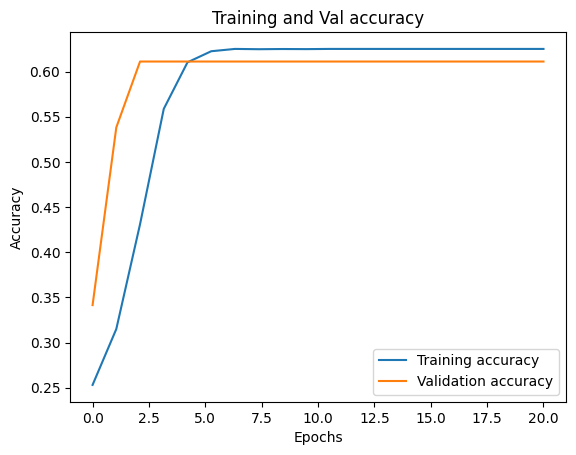

In [ ]:
plt.plot(np.linspace(0, len(m8_history.history['accuracy']), len(m8_history.history['accuracy'])), m8_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(m8_history.history['val_accuracy']), len(m8_history.history['val_accuracy'])), m8_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()